### Description

This implements a CVAE based on https://github.com/unnir/cVAE adapted for promoter sequences and expressions. This does include CNN auxiliary loss, "re-masking" the generated sequence before giving it to the CNN.

In [1]:
from CVAE_unnir_1_2 import *

In [2]:
# Defining hyperparameters
batch_size = 64
epochs = 100
early_stopping_patience = 10
early_stopping_min_delta = 0.01
latent_size = 20
num_masks = 4
min_mask_len = 5
max_mask_len = 20

In [3]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Paths to Data and Pre-trained CNN
path_to_data = '../Data/Combined/LaFleur_supp.csv'
path_to_cvae = '../Models/CVAE_6_1_2.pt'
path_to_cnn = '../Models/CNN_6_1_2.keras'
path_to_summary = '../Testing CVAE/runs/CNN_6_2_summary'

# Set up device
device = get_device()

# Initialize model, optimizer
cnn = KerasModelWrapper(path_to_cnn)
model = CVAE(150, latent_size, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Load data, one-hot encode, mask sequences
onehot_masked, expressions = load_features(path_to_data, num_masks, min_mask_len, max_mask_len)

# Split data into training and testing sets
onehot_masked_train, onehot_masked_test, expressions_train, expressions_test = train_test_split(
    onehot_masked, expressions, test_size=0.2, random_state=seed
)

# Preprocess sequences and expressions into tensors
masked_tensor_train = torch.tensor(np.stack(onehot_masked_train), dtype=torch.float32)
expressions_tensor_train = torch.tensor(expressions_train.values, dtype=torch.float32)
masked_tensor_test = torch.tensor(np.stack(onehot_masked_test), dtype=torch.float32)
expressions_tensor_test = torch.tensor(expressions_test.values, dtype=torch.float32)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(masked_tensor_train, expressions_tensor_train),
    batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(masked_tensor_test, expressions_tensor_test),
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)


c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
# # Train and test the model
# train_losses, test_losses = fit_model(epochs,
#                                         model,
#                                         cnn,
#                                         path_to_summary,
#                                         train_loader,
#                                         test_loader,
#                                         optimizer,
#                                         device,
#                                         early_stopping_patience,
#                                         early_stopping_min_delta
# )

# # Plot the training and testing losses
# plot_losses(train_losses, test_losses)

# # Save the model
# save_model(model, path_to_cvae)

In [5]:
# Load the model
load_model(path_to_cvae)

RecursiveScriptModule(
  original_name=CVAE
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc21): RecursiveScriptModule(original_name=Linear)
  (fc22): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (fc4): RecursiveScriptModule(original_name=Linear)
  (elu): RecursiveScriptModule(original_name=ELU)
  (sigmoid): RecursiveScriptModule(original_name=Sigmoid)
)

In [6]:
P5 = 'AATACTAGAGGTCTTCCGACTTGACAATTAATCATCCGGCTCGTAATTTATGTGGAGCGGGAAGACAACTAGGGG'
plac = 'AATACTAGAGGTCTTCCGACTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGGCGGGAAGACAACTAGGGG'

print(f'P5 expression {predict_with_cnn(cnn, [P5])}')
print(f'Plac expression {predict_with_cnn(cnn, [plac])}')

P5 expression [0.47127414]
Plac expression [0.33783603]


In [12]:
# P5 and Plac promoters with Ns for -10 and -35 regions, pClone plasmid up/disc
masked_sequences = [
    'AATACTAGAGGTCTTCCGACNNNNNNATTAATCATCCGGCTCGTAATTTATGTGGAGCGGGAAGACAACTAGGGG', # P5
    'AATACTAGAGGTCTTCCGACTTGACAATTAATCATCCGGCTCGNNNNNNNTGTGGAGCGGGAAGACAACTAGGGG',
    'AATACTAGAGGTCTTCCGACNNNNNNATTAATCATCCGGCTCGNNNNNNNTGTGGAGCGGGAAGACAACTAGGGG',
    'AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTGTGGAGCGGGAAGACAACTAGGGG',
    
    'AATACTAGAGGTCTTCCGACNNNNNNCTTTATGCTTCCGGCTCGTATGTTGTGTGGGCGGGAAGACAACTAGGGG', # pLac
    'AATACTAGAGGTCTTCCGACTTTACACTTTATGCTTCCGGCTCGNNNNNNNTGTGGGCGGGAAGACAACTAGGGG',
    'AATACTAGAGGTCTTCCGACNNNNNNCTTTATGCTTCCGGCTCGNNNNNNNTGTGGGCGGGAAGACAACTAGGGG',
    'AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTGTGGGCGGGAAGACAACTAGGGG',
]
expressions = [0.5 for _ in range(len(masked_sequences))]

# Generate infills
infilled_sequences, predicted_expressions = generate_infills(model, cnn, masked_sequences, expressions)
for masked, infilled, expressions in zip(masked_sequences, infilled_sequences, predicted_expressions):
    print("Masked:  ", masked)
    print("Infilled:", infilled)
    print("Predicted Expression:", expressions)
    print()

Masked:   AATACTAGAGGTCTTCCGACNNNNNNATTAATCATCCGGCTCGTAATTTATGTGGAGCGGGAAGACAACTAGGGG
Infilled: AATACTAGAGGTCTTCCGACCACGCCATTAATCATCCGGCTCGTAATTTATGTGGAGCGGGAAGACAACTAGGGG
Predicted Expression: 0.36388665

Masked:   AATACTAGAGGTCTTCCGACTTGACAATTAATCATCCGGCTCGNNNNNNNTGTGGAGCGGGAAGACAACTAGGGG
Infilled: AATACTAGAGGTCTTCCGACTTGACAATTAATCATCCGGCTCGCTGCCCTTGTGGAGCGGGAAGACAACTAGGGG
Predicted Expression: 0.44591618

Masked:   AATACTAGAGGTCTTCCGACNNNNNNATTAATCATCCGGCTCGNNNNNNNTGTGGAGCGGGAAGACAACTAGGGG
Infilled: AATACTAGAGGTCTTCCGACACGGTGATTAATCATCCGGCTCGTTGTGGGTGTGGAGCGGGAAGACAACTAGGGG
Predicted Expression: 0.28270924

Masked:   AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTGTGGAGCGGGAAGACAACTAGGGG
Infilled: AATACTAGAGGTCTTCCGACGCCCGCACGTTAATGCCGATTGCAGTCTCTTGTGGAGCGGGAAGACAACTAGGGG
Predicted Expression: 0.24780282

Masked:   AATACTAGAGGTCTTCCGACNNNNNNCTTTATGCTTCCGGCTCGTATGTTGTGTGGGCGGGAAGACAACTAGGGG
Infilled: AATACTAGAGGTCTTCCGACAGATAACTTTATGCTTCCGGCTCGTATGTTGTGTGGGCGGGAAGACAACTAGGGG
Pred

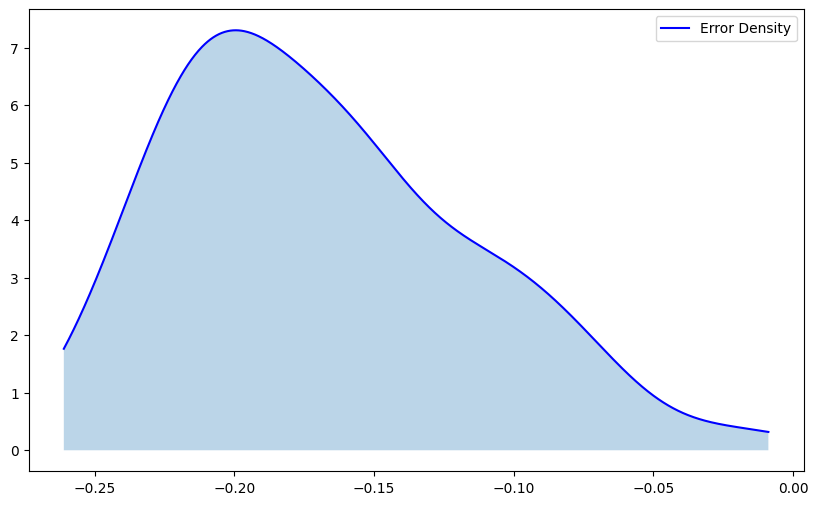

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

num_runs = 100
masked_sequences = ['AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTGTGGGCGGGAAGACAACTAGGGG'] * num_runs
expressions = [0.5] * num_runs

infilled_sequences, predicted_expressions = generate_infills(model, cnn, masked_sequences, expressions)

errors = np.array(predicted_expressions) - np.array(expressions)

kde = gaussian_kde(errors, bw_method='scott')
x_range = np.linspace(min(errors), max(errors), 1000)

plt.figure(figsize=(10, 6))
plt.plot(x_range, kde(x_range), label="Error Density", color="blue")
plt.fill_between(x_range, kde(x_range), alpha=0.3)
plt.legend()
plt.show()
